In [1]:
%matplotlib inline

import numpy as np
import time
import gym
from tqdm import tqdm

from agent import SARSA_agent, Expected_SARSA_agent, Q_agent
from plots import plot_var_history, ValuePlot_2D, FunctionPlot_3D

## Available Agents
        - Semi-Gradient n-step SARSA agent
        - Semi-Gradient n-step Expected SARSA agent
        - Semi-Gradient Q-Learning agent

## Hyperparameters:

### Tile Encoder:
        - number of tiles
        - number of tilings

### Agent:
        - step size
        - epsilon
        - number of bootstrapping steps


In [3]:
class ValuePlot():
    """
    Class to plot the value function of the agent
    """

    def __init__(self, agent, title_key=''):
        self.agent = agent
        ranges = self.agent.tc.var_ranges
        steps = (ranges[:, 1] - ranges[:, 0])/32
        self.X = np.arange(ranges[0][0], ranges[0][1]+steps[0]/2, steps[0])
        self.Y = np.arange(ranges[1][0], ranges[1][1]+steps[1]/2, steps[1])
        values = np.zeros((self.X.size, self.Y.size))
        tiles = np.arange(0, self.agent.tc.num_tilings, 1)

        for i in range(self.X.size):
            for j in range(self.Y.size):
                values[i][j] = -np.max(np.sum(self.agent.value_function[:, self.agent.tc.get_feature([self.X[i], self.Y[j]]), tiles], axis = 1))
        mesh_X, mesh_Y = np.meshgrid(self.X, self.Y, sparse=True)

        kw_args = {'x_label': 'Position', 'y_label': 'Velocity', 'ipython': True,
                    'title': 'steps to goal '+title_key}
        
        self.dia = FunctionPlot_3D(values, mesh_X, mesh_Y, **kw_args)

    def update(self, title_key=''):
        """ Updates the agnet's value funtion plot """
        values = np.zeros((self.X.size, self.Y.size))
        tiles = np.arange(0, self.agent.tc.num_tilings, 1)
        for i in range(self.X.size):
            for j in range(self.Y.size):
                values[i][j] = -np.max(np.sum(self.agent.value_function[:, self.agent.tc.get_feature([self.X[i], self.Y[j]]), tiles], axis = 1))
        mesh_X, mesh_Y = np.meshgrid(self.X, self.Y, sparse=True)
        
        self.dia.update(values, mesh_X, mesh_Y, title=('steps to goal ' + title_key))

In [4]:
class StateFrequencyPlot():
    """
    Class to plot a color mesh indicating the frequency with which 
    the agent visits each state in the state space
    """

    def __init__(self, agent, title_key=''):
        self.agent = agent
        ranges = self.agent.tc.var_ranges
        self.left_limit = ranges[:, 0]
        self.right_limit = ranges[:, 1]
        self.steps = [0.1, 0.01]
        cell_counts = np.round((self.right_limit - self.left_limit) / self.steps)
        self.visits = np.zeros((int(cell_counts[1]), int(cell_counts[0])))
        self.X = np.round(np.arange(self.left_limit[0], self.right_limit[0] + self.steps[0]/2, self.steps[0]), 1)
        self.Y = np.round(np.arange(self.left_limit[1], self.right_limit[1] + self.steps[1]/2, self.steps[1]), 2)
        self.X, self.Y = np.meshgrid(self.X, self.Y, sparse=True)

        kw_args = {'x_label': 'Position', 'y_label': 'Velocity', 'ipython': True,
                    'title': 'state visit frequency '+title_key}

        self.dia = ValuePlot_2D(self.visits, self.X, self.Y, **kw_args)

    def update(self, title_key=''):
        """ Updates the state visit frequency plot """
        self.dia.update(self.visits, self.X, self.Y, 'state visit frequency '+title_key)


In [5]:
# Setup environment
env = gym.make('MountainCar-v0').env
obs_limits = np.transpose(np.vstack((env.observation_space.low, env.observation_space.high)))
# Agent default parameters
agent_info = {
    "n_step": 1,
    "num_actions": env.action_space.n,
    "epsilon": 0.1,
    "step_size": 0.5,
    "discount": 1,
    "num_tilings": 8,
    "num_tiles": [8, 8],
    "obs_limits": obs_limits
}

In [6]:
def run_experient(env, num_runs, num_episodes, settings,
            render_env = True, plot_value_func = False, plot_state_visit = False):
    reward_history = []
    for i, (Agent, params_dict) in enumerate(settings):
        print("Parameter Setting {}".format(i+1))
        reward_history.append([])
        # Set the parameters for the current run
        current_agent_info = agent_info.copy()
        for param in list(params_dict.keys()):
            current_agent_info[param] = params_dict[param]
        # Start the runs for each setting
        for run in tqdm(range(1, num_runs+1)):
            reward_history[i].append([])
            env.seed(run)
            current_agent_info["seed"] = run
            agent = Agent(current_agent_info)
            # Instantiate plot for value function
            if plot_value_func:
                value_plot = ValuePlot(agent)
            # Instantiate plot for state visitation count
            if plot_state_visit:
                state_freq_plot =  StateFrequencyPlot(agent)
            # Start the episodes
            for episode in range(1, num_episodes+1):
                if episode > 50:
                    agent.d_step_size = max(agent.step_size * np.exp(-episode/50), 0.01)
                observation  = env.reset()
                done = False
                time_step = 0
                action = agent.start(observation)
                # Start interaction with environment
                while not done:
                    if render_env:
                        env.render()
                        time.sleep(0.001)
                    observation, reward, done, info = env.step(action)
                    time_step +=1
                    if done:
                        agent.end(reward)
                    else:
                        action = agent.take_step(reward, observation)
                    # Update state visits
                    if plot_state_visit:
                        pos = int((observation[0]-state_freq_plot.left_limit[0]) / state_freq_plot.steps[0])
                        vel = int((observation[1]-state_freq_plot.left_limit[1]) / state_freq_plot.steps[1])
                        state_freq_plot.visits[vel, pos] +=1
                        if (episode in [1, 10, 25, 100, 500, 1000, 200, 3500, 5000] and done):
                            state_freq_plot.update("after {} episodes".format(episode)) 
                    # Plot the value function at fixed intervals
                    if plot_value_func:
                        if (time_step % 200 == 0 and episode == 1):
                            value_plot.update("after {} timesteps".format(time_step))
                        elif (episode in [10, 50, 100, 200, 500, 1000, 2000, 3500, 5000] and done):
                            value_plot.update("after {} episodes".format(episode))
                reward_history[i][run-1].append(time_step)
    return reward_history, agent

In [7]:
# Uncomment Below to run experiment

# Experiment to identify tile encoding hyperparameters performance

settings = [(SARSA_agent, {"num_tilings": 8, "num_tiles": [8, 8]}), 
               (SARSA_agent, {"num_tilings": 4, "num_tiles": [8, 8]}),
               (SARSA_agent, {"num_tilings": 8, "num_tiles": [4, 4]}),
               (SARSA_agent, {"num_tilings": 4, "num_tiles": [16, 16]}),
               (SARSA_agent, {"num_tilings": 8, "num_tiles": [16, 16]}),
               (SARSA_agent, {"num_tilings": 16, "num_tiles": [8, 8]})]

reward_hist, _ = run_experient(env, 50, 500, settings)

kw_args = {'x_label': 'Episode', 'y_label': 'Steps per episode (log scale)\n(Averaged over 50 runs)',
            'log_scale': True}

labels = ["tilings: 8    tiles: 8x8", "tilings: 4    tiles: 8x8",
          "tilings: 8    tiles: 4x4", "tilings: 4    tiles: 16x16",
          "tilings: 8    tiles: 16x16", "tilings: 16    tiles: 8x8"]

plot_var_history(reward_hist, labels, **kw_args)

  4%|▍         | 2/50 [06:15<2:29:40, 187.10s/it]

KeyboardInterrupt: 

In [7]:
# Uncomment Below to run experiment

# Experiment to visualize the learning of the value function
settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5})]

rewards, agent = run_experient(env, 1, 5000, settings,  plot_value_func = True, plot_state_visit=False)

100%|██████████| 1/1 [00:17<00:00, 17.92s/it]


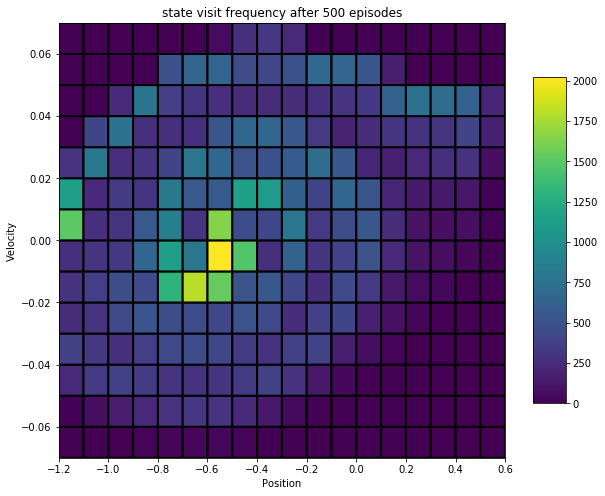

In [8]:
# Uncomment Below to run experiment

# Experiment to visualize agent exploration
settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5})]

_, _ = run_experient(env, 1, 5000, settings,  plot_value_func = False, plot_state_visit=True)

In [9]:
# Uncomment Below to run experiment

# Experiment to effect of bootstrapping in sarsa

settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5}), (SARSA_agent, {"n_step": 2, "step_size": 0.425}),
            (SARSA_agent, {"n_step": 4, "step_size": 0.375}), (SARSA_agent, {"n_step": 8, "step_size": 0.3})]

reward_hist, _ = run_experient(env, 50, 500, settings)

labels = ["1 step", "2 step", "4 step", "8 step"]

kw_args = {'x_label': 'Episode', 'y_label': 'Steps per episode (log scale)\n(Averaged over 50 runs)',
            'log_scale': True}

plot_var_history(reward_hist, labels, **kw_args)

  0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [10]:
# Uncomment Below to run experiment

# Experiment to effect of bootstrapping in sarsa

settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5}), (Expected_SARSA_agent, {"n_step": 1, "step_size": 0.5}),
            (Q_agent, {"n_step": 1, "step_size": 0.5})]

reward_hist, _ = run_experient(env, 50, 500, settings)

color_list = ['b', 'g', 'r', 'y', 'k', 'm']
labels = ["SARSA (1 step)", "Expected SARSA (1 step)", "Q Learning (1 step)"]

plot_var_history(reward_hist, labels, **kw_args)

0%|          | 0/50 [00:00<?, ?it/s]Parameter Setting 1
